## Training VGG16 on CIFAR10 Dataset

In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets 
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
from initialise import *

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 7

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Number of GPUs available: ',torch.cuda.device_count())
device

Number of GPUs available:  1


device(type='cuda', index=0)

In [4]:
#constructing a vgg block
class ConvBlock(nn.Module):
    
    def __init__(self, in_feature, out_feature, num_layers, pool = False):
        super(ConvBlock, self).__init__()
        channels = [in_feature] + [out_feature for i in range(num_layers)]
        layers = []
        for i in range(num_layers):
            layers.append(nn.Conv2d(channels[i], channels[i+1], kernel_size= 3, padding= 1, bias = True))
            layers.append(nn.BatchNorm2d(channels[i+1], affine = True, track_running_stats= True))
            layers.append(nn.ReLU())
            if pool:
                layers.append(nn.MaxPool2d(kernel_size= 2, stride = 2, padding= 0))
            
        self.op = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.op(x)

In [5]:
class Vgg(nn.Module):
    
    def __init__(self, pretrained = False):
        super(Vgg, self).__init__()
        self.conv_block1 = ConvBlock(3, 64, 2)
        self.conv_block2 = ConvBlock(64, 128, 2)
        self.conv_block3 = ConvBlock(128, 256, 3)
        self.conv_block4 = ConvBlock(256, 512, 3)
        self.conv_block5 = ConvBlock(512, 512, 3)
        self.fc1 = nn.Linear(in_features= 512*2*2, out_features= 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        
        #initialise weights
        initialise_weights(self)
        
    def forward(self, x):
        #feed forward
        x = self.conv_block1(x)
        x = F.max_pool2d(x, kernel_size= 2, stride= 2, padding= 0) # /16
        x = self.conv_block2(x)
        x = F.max_pool2d(x, kernel_size= 2, stride= 2, padding= 0) # /8
        x = self.conv_block3(x)
        x = F.max_pool2d(x, kernel_size= 2, stride= 2, padding= 0) # /4
        x = self.conv_block4(x)
        x = F.max_pool2d(x, kernel_size= 2, stride= 1, padding= 0) # /2
        x = self.conv_block5(x)
        x = F.max_pool2d(x, kernel_size= 2, stride= 1, padding= 0)
        
        B, C, H, W = x.shape  
        l = x.reshape(-1, C*H*W)   #reshape the out of conv layers as per first FC layer
        l = self.fc1(l)
        l = F.relu(l)
        l = F.dropout(l)
        l = self.fc2(l)
        l = F.relu(l)
        l = F.dropout(l)
        out = self.fc3(l)
        
        return F.softmax(out,1)
    

In [6]:
class Data():
    
    def __init__(self):
        
        self.train_set = datasets.CIFAR10(
        root = './data',
        train = True,
        download = True,
        transform = transforms.Compose([transforms.ToTensor()])
        )

        self.test_set = datasets.CIFAR10(
        root= './data',
        train= False,
        download = True,
        transform = transforms.Compose([transforms.ToTensor()])
        )
        
    def get_data(self):
        return [self.train_set, self.test_set]

In [7]:
data = Data()
train, test = data.get_data()

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_loader = torch.utils.data.DataLoader(train, batch_size= 512, shuffle= True)
test_loader = torch.utils.data.DataLoader(test, batch_size= 10000, shuffle= True)

In [9]:
images, labels = next(iter(train_loader))

In [10]:
len(train_loader)

98

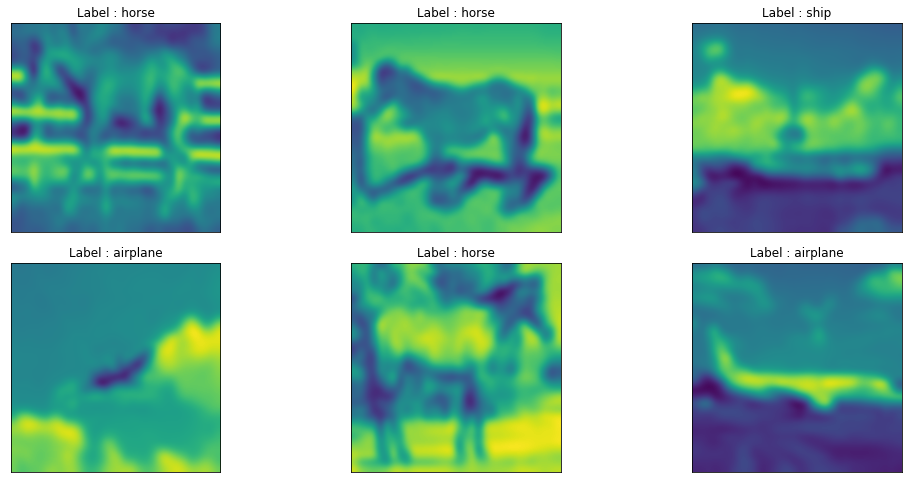

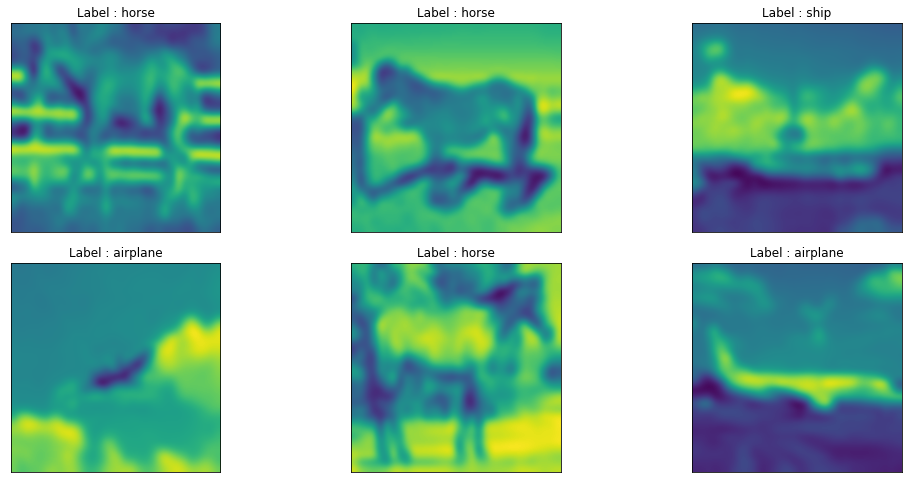

In [11]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], interpolation='bicubic')
  plt.title("Label : {}".format(train.classes[labels[i]]))
  plt.xticks([])
  plt.yticks([])
fig

In [12]:

def get_network(pretrained = False):
    if pretrained:
        model_vgg = models.vgg16(pretrained= True)
        for child in model_vgg.children():
            
    else:
        net = Vgg()

    return net.to(device)


# use multiple gpus
#if torch.cuda.device_count() > 1:
    #net = nn.DataParallel(net)
    


Vgg(
  (conv_block1): ConvBlock(
    (op): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (conv_block2): ConvBlock(
    (op): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (conv_block3): ConvBlock(
    (op): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
def train(epoch, losses):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        losses.append(loss.item())
        _, predicted = outputs.max(1)  #this returns values and labels
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(batch_idx, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [14]:
def test(test_loader,test_losses ):
    
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            
            test_losses.append(loss.item())
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            print('Loss: %.3f | Acc: %.3f%%'
                  % (test_loss, 100.*correct/len(test_loader.dataset)))

In [15]:

losses = []
test_losses = []

epochs = 10

net = get_network(pretrained = True)
for epoch in range(1,epochs+1):
    train(epoch, losses)
    test(test_loader, test_losses)


Epoch: 1
0 98 Loss: 2.304 | Acc: 7.617% (39/512)
1 98 Loss: 2.304 | Acc: 7.617% (78/1024)
2 98 Loss: 2.304 | Acc: 7.943% (122/1536)
3 98 Loss: 2.304 | Acc: 8.691% (178/2048)
4 98 Loss: 2.304 | Acc: 9.141% (234/2560)
5 98 Loss: 2.304 | Acc: 9.212% (283/3072)
6 98 Loss: 2.303 | Acc: 9.459% (339/3584)
7 98 Loss: 2.303 | Acc: 9.619% (394/4096)
8 98 Loss: 2.303 | Acc: 9.852% (454/4608)
9 98 Loss: 2.303 | Acc: 9.785% (501/5120)
10 98 Loss: 2.303 | Acc: 9.943% (560/5632)
11 98 Loss: 2.303 | Acc: 9.961% (612/6144)
12 98 Loss: 2.303 | Acc: 10.021% (667/6656)
13 98 Loss: 2.303 | Acc: 10.170% (729/7168)
14 98 Loss: 2.303 | Acc: 10.091% (775/7680)
15 98 Loss: 2.303 | Acc: 10.132% (830/8192)
16 98 Loss: 2.302 | Acc: 10.133% (882/8704)
17 98 Loss: 2.303 | Acc: 9.972% (919/9216)
18 98 Loss: 2.303 | Acc: 10.084% (981/9728)
19 98 Loss: 2.302 | Acc: 10.098% (1034/10240)
20 98 Loss: 2.303 | Acc: 9.989% (1074/10752)
21 98 Loss: 2.302 | Acc: 10.005% (1127/11264)
22 98 Loss: 2.303 | Acc: 9.995% (1177/11776

83 98 Loss: 2.297 | Acc: 11.193% (4814/43008)
84 98 Loss: 2.297 | Acc: 11.199% (4874/43520)
85 98 Loss: 2.297 | Acc: 11.226% (4943/44032)
86 98 Loss: 2.297 | Acc: 11.207% (4992/44544)
87 98 Loss: 2.297 | Acc: 11.193% (5043/45056)
88 98 Loss: 2.297 | Acc: 11.216% (5111/45568)
89 98 Loss: 2.297 | Acc: 11.233% (5176/46080)
90 98 Loss: 2.297 | Acc: 11.234% (5234/46592)
91 98 Loss: 2.296 | Acc: 11.258% (5303/47104)
92 98 Loss: 2.296 | Acc: 11.246% (5355/47616)
93 98 Loss: 2.296 | Acc: 11.255% (5417/48128)
94 98 Loss: 2.296 | Acc: 11.256% (5475/48640)
95 98 Loss: 2.296 | Acc: 11.263% (5536/49152)
96 98 Loss: 2.296 | Acc: 11.262% (5593/49664)
97 98 Loss: 2.296 | Acc: 11.248% (5624/50000)
Loss: 2.293 | Acc: 11.180%

Epoch: 3
0 98 Loss: 2.293 | Acc: 10.352% (53/512)
1 98 Loss: 2.293 | Acc: 10.449% (107/1024)
2 98 Loss: 2.293 | Acc: 10.417% (160/1536)
3 98 Loss: 2.294 | Acc: 10.059% (206/2048)
4 98 Loss: 2.294 | Acc: 10.430% (267/2560)
5 98 Loss: 2.293 | Acc: 10.807% (332/3072)
6 98 Loss: 2.293 

67 98 Loss: 2.281 | Acc: 12.224% (4256/34816)
68 98 Loss: 2.281 | Acc: 12.228% (4320/35328)
69 98 Loss: 2.281 | Acc: 12.235% (4385/35840)
70 98 Loss: 2.281 | Acc: 12.263% (4458/36352)
71 98 Loss: 2.281 | Acc: 12.286% (4529/36864)
72 98 Loss: 2.281 | Acc: 12.318% (4604/37376)
73 98 Loss: 2.280 | Acc: 12.328% (4671/37888)
74 98 Loss: 2.280 | Acc: 12.344% (4740/38400)
75 98 Loss: 2.280 | Acc: 12.377% (4816/38912)
76 98 Loss: 2.280 | Acc: 12.388% (4884/39424)
77 98 Loss: 2.280 | Acc: 12.475% (4982/39936)
78 98 Loss: 2.280 | Acc: 12.520% (5064/40448)
79 98 Loss: 2.280 | Acc: 12.581% (5153/40960)
80 98 Loss: 2.280 | Acc: 12.609% (5229/41472)
81 98 Loss: 2.280 | Acc: 12.676% (5322/41984)
82 98 Loss: 2.280 | Acc: 12.705% (5399/42496)
83 98 Loss: 2.280 | Acc: 12.756% (5486/43008)
84 98 Loss: 2.280 | Acc: 12.792% (5567/43520)
85 98 Loss: 2.280 | Acc: 12.804% (5638/44032)
86 98 Loss: 2.279 | Acc: 12.859% (5728/44544)
87 98 Loss: 2.279 | Acc: 12.897% (5811/45056)
88 98 Loss: 2.279 | Acc: 12.917% (

51 98 Loss: 2.255 | Acc: 20.639% (5495/26624)
52 98 Loss: 2.255 | Acc: 20.640% (5601/27136)
53 98 Loss: 2.255 | Acc: 20.671% (5715/27648)
54 98 Loss: 2.255 | Acc: 20.685% (5825/28160)
55 98 Loss: 2.255 | Acc: 20.717% (5940/28672)
56 98 Loss: 2.255 | Acc: 20.751% (6056/29184)
57 98 Loss: 2.254 | Acc: 20.750% (6162/29696)
58 98 Loss: 2.255 | Acc: 20.763% (6272/30208)
59 98 Loss: 2.254 | Acc: 20.781% (6384/30720)
60 98 Loss: 2.254 | Acc: 20.777% (6489/31232)
61 98 Loss: 2.254 | Acc: 20.782% (6597/31744)
62 98 Loss: 2.254 | Acc: 20.790% (6706/32256)
63 98 Loss: 2.254 | Acc: 20.801% (6816/32768)
64 98 Loss: 2.254 | Acc: 20.811% (6926/33280)
65 98 Loss: 2.253 | Acc: 20.824% (7037/33792)
66 98 Loss: 2.253 | Acc: 20.881% (7163/34304)
67 98 Loss: 2.253 | Acc: 20.921% (7284/34816)
68 98 Loss: 2.253 | Acc: 20.927% (7393/35328)
69 98 Loss: 2.253 | Acc: 20.951% (7509/35840)
70 98 Loss: 2.253 | Acc: 20.956% (7618/36352)
71 98 Loss: 2.253 | Acc: 20.942% (7720/36864)
72 98 Loss: 2.253 | Acc: 20.955% (

33 98 Loss: 2.204 | Acc: 24.707% (4301/17408)
34 98 Loss: 2.204 | Acc: 24.682% (4423/17920)
35 98 Loss: 2.204 | Acc: 24.718% (4556/18432)
36 98 Loss: 2.204 | Acc: 24.620% (4664/18944)
37 98 Loss: 2.204 | Acc: 24.548% (4776/19456)
38 98 Loss: 2.204 | Acc: 24.559% (4904/19968)
39 98 Loss: 2.205 | Acc: 24.526% (5023/20480)
40 98 Loss: 2.204 | Acc: 24.586% (5161/20992)
41 98 Loss: 2.204 | Acc: 24.637% (5298/21504)
42 98 Loss: 2.204 | Acc: 24.641% (5425/22016)
43 98 Loss: 2.204 | Acc: 24.600% (5542/22528)
44 98 Loss: 2.204 | Acc: 24.609% (5670/23040)
45 98 Loss: 2.204 | Acc: 24.609% (5796/23552)
46 98 Loss: 2.204 | Acc: 24.568% (5912/24064)
47 98 Loss: 2.204 | Acc: 24.597% (6045/24576)
48 98 Loss: 2.204 | Acc: 24.581% (6167/25088)
49 98 Loss: 2.204 | Acc: 24.566% (6289/25600)
50 98 Loss: 2.204 | Acc: 24.594% (6422/26112)
51 98 Loss: 2.204 | Acc: 24.583% (6545/26624)
52 98 Loss: 2.204 | Acc: 24.561% (6665/27136)
53 98 Loss: 2.204 | Acc: 24.494% (6772/27648)
54 98 Loss: 2.204 | Acc: 24.506% (

15 98 Loss: 2.180 | Acc: 27.100% (2220/8192)
16 98 Loss: 2.179 | Acc: 27.091% (2358/8704)
17 98 Loss: 2.180 | Acc: 26.953% (2484/9216)
18 98 Loss: 2.179 | Acc: 27.200% (2646/9728)
19 98 Loss: 2.179 | Acc: 27.207% (2786/10240)
20 98 Loss: 2.179 | Acc: 27.186% (2923/10752)
21 98 Loss: 2.179 | Acc: 27.219% (3066/11264)
22 98 Loss: 2.179 | Acc: 27.157% (3198/11776)
23 98 Loss: 2.180 | Acc: 27.051% (3324/12288)
24 98 Loss: 2.180 | Acc: 26.922% (3446/12800)
25 98 Loss: 2.181 | Acc: 26.840% (3573/13312)
26 98 Loss: 2.180 | Acc: 26.859% (3713/13824)
27 98 Loss: 2.180 | Acc: 27.023% (3874/14336)
28 98 Loss: 2.179 | Acc: 27.155% (4032/14848)
29 98 Loss: 2.179 | Acc: 27.155% (4171/15360)
30 98 Loss: 2.179 | Acc: 27.104% (4302/15872)
31 98 Loss: 2.179 | Acc: 27.075% (4436/16384)
32 98 Loss: 2.179 | Acc: 27.143% (4586/16896)
33 98 Loss: 2.179 | Acc: 27.189% (4733/17408)
34 98 Loss: 2.179 | Acc: 27.210% (4876/17920)
35 98 Loss: 2.179 | Acc: 27.214% (5016/18432)
36 98 Loss: 2.179 | Acc: 27.207% (5154

Text(0.5,0,'Epochs')

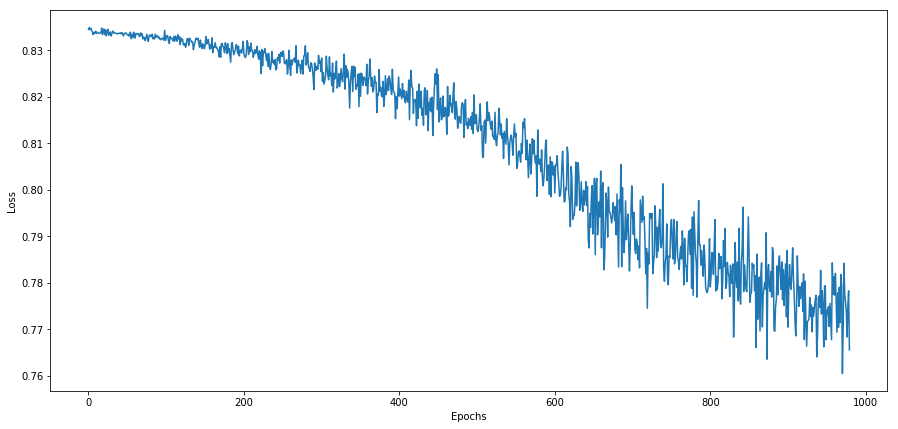

In [16]:
log_loss = [np.log(x) for x in losses]
plt.plot(log_loss)

plt.ylabel('Loss')
plt.xlabel('Epochs')